# Feature Engineering & Modelling

### Importing the necessary modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Reading the Dataset

In [2]:
df = pd.read_csv(r"data/loan_data.csv")

In [3]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


# Data Cleaning

In [4]:
df.drop(columns=["Loan_ID"],inplace=True)

In [5]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


In [6]:
df.isna().mean() * 100

Gender               1.312336
Married              0.000000
Dependents           2.099738
Education            0.000000
Self_Employed        5.511811
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           0.000000
Loan_Amount_Term     2.887139
Credit_History       7.874016
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

In [7]:
df.isna().mean()[df.isna().mean() * 100 > 0] * 100

Gender              1.312336
Dependents          2.099738
Self_Employed       5.511811
Loan_Amount_Term    2.887139
Credit_History      7.874016
dtype: float64

In [8]:
features_na = df.isna().mean()[df.isna().mean() * 100 > 0].index
features_na

Index(['Gender', 'Dependents', 'Self_Employed', 'Loan_Amount_Term',
       'Credit_History'],
      dtype='object')

In [9]:
df[features_na].describe()

,Loan_Amount_Term,Credit_History
count,370.000000,351.000000
mean,340.864865,0.837607
std,68.549257,0.369338
min,12.000000,0.000000
25%,360.000000,1.000000
50%,360.000000,1.000000
75%,360.000000,1.000000
max,480.000000,1.000000


In [10]:
df["Loan_Amount_Term"].fillna(df["Loan_Amount_Term"].median(),inplace=True)
df["Credit_History"].fillna(df["Credit_History"].mode()[0],inplace=True)
df["Dependents"].fillna(df["Dependents"].mode()[0],inplace=True)
df["Gender"].fillna(df["Gender"].mode()[0],inplace=True)
df["Self_Employed"].fillna(df["Self_Employed"].mode()[0],inplace=True)

# Feature Engineering

In [11]:
df["TotalIncome"] = df["ApplicantIncome"] + df["CoapplicantIncome"]

df.drop(columns=["ApplicantIncome","CoapplicantIncome"],inplace=True)

In [12]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome
0,Male,Yes,1,Graduate,No,128.0,360.0,1.0,Rural,N,6091.0
1,Male,Yes,0,Graduate,Yes,66.0,360.0,1.0,Urban,Y,3000.0
2,Male,Yes,0,Not Graduate,No,120.0,360.0,1.0,Urban,Y,4941.0
3,Male,No,0,Graduate,No,141.0,360.0,1.0,Urban,Y,6000.0
4,Male,Yes,0,Not Graduate,No,95.0,360.0,1.0,Urban,Y,3849.0


# Types of Features

In [13]:
numeric_features = df.select_dtypes(include=np.number).columns
len(numeric_features)

4

In [14]:
categorical_features = df.select_dtypes(exclude=np.number).columns
len(categorical_features)

7

In [15]:
discrete_features = [feature for feature in numeric_features if len(df[feature].unique())<=25]
len(discrete_features)

2

In [16]:
continuous_features = [feature for feature in numeric_features if feature not in discrete_features]
len(continuous_features)

2

# Multicollinearity

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(features,df):

    X = df[features]
    X["intercept"] = 1

    vif = pd.DataFrame()
    vif["variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    vif = vif[vif["variable"]!="intercept"]

    return vif

In [18]:
compute_vif(numeric_features,df)

,variable,VIF
0,LoanAmount,1.104492
1,Loan_Amount_Term,1.024910
2,Credit_History,1.003719
3,TotalIncome,1.090378


In [19]:
from scipy.stats import chi2_contingency
chi2_test = []
for feature in categorical_features:
    if chi2_contingency(pd.crosstab(df['Loan_Status'], df[feature]))[1] < 0.05:
        chi2_test.append('Reject Null Hypothesis')
    else:
        chi2_test.append('Fail to Reject Null Hypothesis')
result = pd.DataFrame(data=[categorical_features, chi2_test]).T
result.columns = ['Column', 'Hypothesis Result']
result

,Column,Hypothesis Result
0,Gender,Fail to Reject Null Hypothesis
1,Married,Fail to Reject Null Hypothesis
2,Dependents,Fail to Reject Null Hypothesis
3,Education,Fail to Reject Null Hypothesis
4,Self_Employed,Fail to Reject Null Hypothesis
5,Property_Area,Reject Null Hypothesis
6,Loan_Status,Reject Null Hypothesis


# Outlier Handling

In [20]:
continuous_features

['LoanAmount', 'TotalIncome']

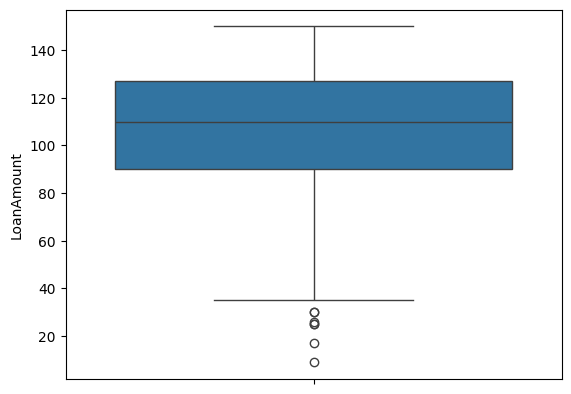

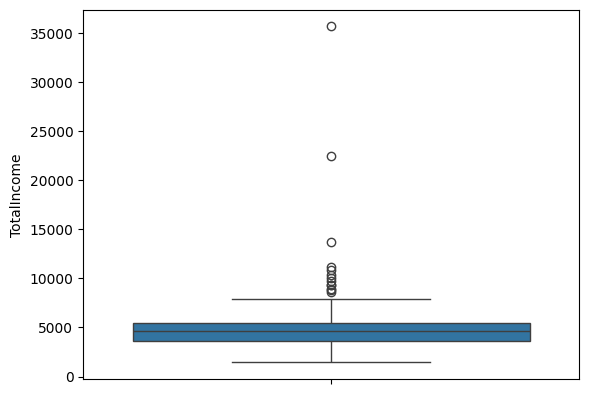

In [21]:
for feature in continuous_features:
  sns.boxplot(df[feature])
  plt.show()

In [22]:
def detect_outliers(col):

  percent25 = df[col].quantile(0.25)
  percent75 = df[col].quantile(0.75)

  IQR = percent75 - percent25

  lower_limit = percent25 - 1.5 * IQR
  upper_limit = percent75 + 1.5 * IQR

  print(f"###{col}###")
  print("Upper Limit",upper_limit)
  print("Lower Limit",lower_limit)

  df.loc[df[col]>upper_limit,col] = upper_limit
  df.loc[df[col]<lower_limit,col] = lower_limit

  return df


In [23]:
for col in continuous_features:
  detect_outliers(col)

###LoanAmount###
Upper Limit 182.5
Lower Limit 34.5
###TotalIncome###
Upper Limit 8254.0
Lower Limit 910.0


# Data Transformations

In [24]:
df[continuous_features].skew()

LoanAmount    -0.696848
TotalIncome    0.512330
dtype: float64

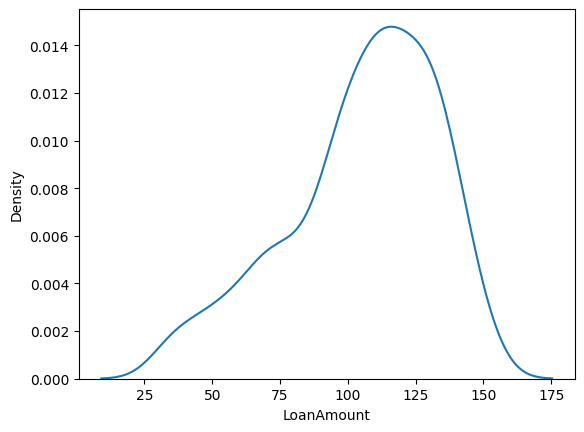

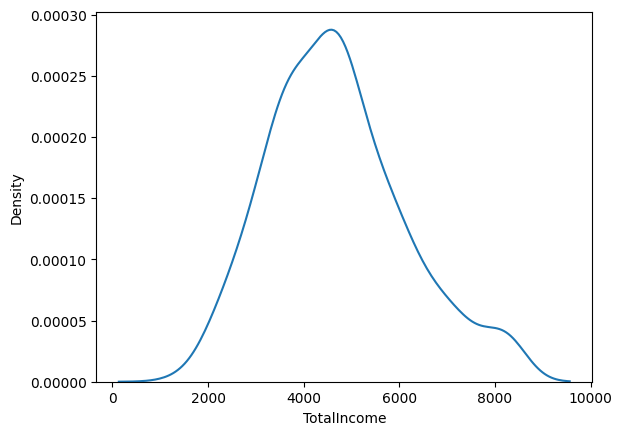

In [25]:
for i in continuous_features:
  sns.kdeplot(df[i])
  plt.show()

# Export the Data to CSV

In [26]:
df.to_csv("loan_data_cleaned.csv",index=False)

# Split X & y

In [27]:
X = df.drop(columns=["Loan_Status"])
y = df["Loan_Status"]

In [28]:
X.head()

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,TotalIncome
0,Male,Yes,1,Graduate,No,128.0,360.0,1.0,Rural,6091.0
1,Male,Yes,0,Graduate,Yes,66.0,360.0,1.0,Urban,3000.0
2,Male,Yes,0,Not Graduate,No,120.0,360.0,1.0,Urban,4941.0
3,Male,No,0,Graduate,No,141.0,360.0,1.0,Urban,6000.0
4,Male,Yes,0,Not Graduate,No,95.0,360.0,1.0,Urban,3849.0


In [29]:
y.head()

0    N
1    Y
2    Y
3    Y
4    Y
Name: Loan_Status, dtype: object

In [30]:
# Identify categorical features by selecting columns with data type 'object'
categorical_features = X.select_dtypes(include="object").columns

# Identify numeric features by selecting columns with data types other than 'object'
numeric_features = X.select_dtypes(exclude="object").columns

In [31]:
categorical_features

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area'],
      dtype='object')

In [32]:
numeric_features

Index(['LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'TotalIncome'], dtype='object')

In [33]:
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn.compose import ColumnTransformer

sc = StandardScaler()
oe = OrdinalEncoder()

preprocessor = ColumnTransformer([
    ("oe",oe,categorical_features),
    ("sc",sc,numeric_features)
])

X = preprocessor.fit_transform(X)

y = y.map({"Y":1,"N":0})

In [34]:
X.shape

(381, 10)

# Train, Test & Split

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Model Training

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [38]:
models = {
    "DecisionTree":DecisionTreeClassifier(),
    "SVC":SVC(),
    "LogisticRegression":LogisticRegression(),
    "RandomForest":RandomForestClassifier(),
    "AdaBoost":AdaBoostClassifier(),
    "GradientBoost":GradientBoostingClassifier(),
    "XGBoost":XGBClassifier(),
    "KNN":KNeighborsClassifier()
}

for i in range(len(list(models))):
  model = list(models.values())[i]
  model.fit(X_train, y_train) # Train model

  # Make predictions
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  # Training set performance
  model_train_accuracy = accuracy_score(y_train, y_train_pred)
  model_train_confusion_matrix = confusion_matrix(y_train, y_train_pred)
  model_train_classification_report = classification_report(y_train, y_train_pred)

  # Test set performance
  model_test_accuracy = accuracy_score(y_test, y_test_pred)
  model_test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
  model_test_classification_report = classification_report(y_test, y_test_pred)

  print(list(models.keys())[i])

  print("Model performance for Training set")
  print("-"*35)
  print(f"Accuracy Score: {model_train_accuracy}")

  print(f"Confusion Matrix: \n{model_train_confusion_matrix}")

  print(f"Classification Report: \n{model_train_classification_report}")

  print()

  print("Model performance for Test set")
  print("-"*35)
  print(f"Accuracy Score: {model_test_accuracy}")

  print(f"Confusion Matrix: \n{model_test_confusion_matrix}")

  print(f"Classification Report: \n{model_test_classification_report}")

  print("*" * 50)

DecisionTree
Model performance for Training set
-----------------------------------
Accuracy Score: 1.0
Confusion Matrix: 
[[ 89   0]
 [  0 215]]
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       1.00      1.00      1.00       215

    accuracy                           1.00       304
   macro avg       1.00      1.00      1.00       304
weighted avg       1.00      1.00      1.00       304


Model performance for Test set
-----------------------------------
Accuracy Score: 0.7142857142857143
Confusion Matrix: 
[[12  9]
 [13 43]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.48      0.57      0.52        21
           1       0.83      0.77      0.80        56

    accuracy                           0.71        77
   macro avg       0.65      0.67      0.66        77
weighted avg       0.73      0.71      0.72        77

***********

**Conclusion**
- Best Balanced Model, Random Forest.

In [39]:
rf_params = {
    'n_estimators': [100, 200, 300,500],
    'max_depth': [5,7,15,20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

In [40]:
from sklearn.model_selection import RandomizedSearchCV

In [41]:
model = RandomForestClassifier()

random = RandomizedSearchCV(
        estimator=model,
        param_distributions=rf_params,
        n_iter=100,
        cv=3,
        verbose=2
    )

In [42]:
random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.3s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.3s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'max_depth': [5, 7, 15, 20],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500]},
                   verbose=2)

In [43]:
print(random.best_score_)
print(random.best_params_)

0.8486701611337604
{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 7}


In [44]:
models = {
    "RandomForest":RandomForestClassifier(n_estimators=500,min_samples_split=5,min_samples_leaf=4, max_features='sqrt', max_depth=20),
}

for i in range(len(list(models))):
  model = list(models.values())[i]
  model.fit(X_train, y_train) # Train model

  # Make predictions
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  # Training set performance
  model_train_accuracy = accuracy_score(y_train, y_train_pred)
  model_train_confusion_matrix = confusion_matrix(y_train, y_train_pred)
  model_train_classification_report = classification_report(y_train, y_train_pred)

  # Test set performance
  model_test_accuracy = accuracy_score(y_test, y_test_pred)
  model_test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
  model_test_classification_report = classification_report(y_test, y_test_pred)

  print(list(models.keys())[i])

  print("Model performance for Training set")
  print("-"*35)
  print(f"Accuracy Score: {model_train_accuracy}")

  print(f"Confusion Matrix: \n{model_train_confusion_matrix}")

  print(f"Classification Report: \n{model_train_classification_report}")

  print()

  print("Model performance for Test set")
  print("-"*35)
  print(f"Accuracy Score: {model_test_accuracy}")

  print(f"Confusion Matrix: \n{model_test_confusion_matrix}")

  print(f"Classification Report: \n{model_test_classification_report}")

  print("*" * 50)

RandomForest
Model performance for Training set
-----------------------------------
Accuracy Score: 0.8519736842105263
Confusion Matrix: 
[[ 48  41]
 [  4 211]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.54      0.68        89
           1       0.84      0.98      0.90       215

    accuracy                           0.85       304
   macro avg       0.88      0.76      0.79       304
weighted avg       0.86      0.85      0.84       304


Model performance for Test set
-----------------------------------
Accuracy Score: 0.8181818181818182
Confusion Matrix: 
[[ 7 14]
 [ 0 56]]
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.33      0.50        21
           1       0.80      1.00      0.89        56

    accuracy                           0.82        77
   macro avg       0.90      0.67      0.69        77
weighted avg       0.85      0.82      0.78        

In [45]:
from sklearn.model_selection import cross_val_score,KFold

kfold = KFold(n_splits=5,shuffle=True,random_state=42)

cv = cross_val_score(RandomForestClassifier(n_estimators=500,min_samples_split=5,min_samples_leaf=4, max_features='sqrt', max_depth=20),X_test,y_test,cv=kfold,scoring="accuracy",n_jobs=-1)

rf_cv = cv.mean()*100
print('Random Forest Classifier CV Mean Accuarcy Score is {}'.format(rf_cv))


Random Forest Classifier CV Mean Accuarcy Score is 70.0


In [46]:
best_model = RandomForestClassifier(n_estimators=500,min_samples_split=5,min_samples_leaf=4, max_features='sqrt', max_depth=20)
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test,y_pred)
cr = classification_report(y_test,y_pred)

In [47]:
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.33      0.50        21
           1       0.80      1.00      0.89        56

    accuracy                           0.82        77
   macro avg       0.90      0.67      0.69        77
weighted avg       0.85      0.82      0.78        77



# Save the Model using Pickle

In [48]:
import pickle

In [49]:
pickle.dump(best_model,open("loan_model.pkl","wb"))